In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshchanda","key":"3eb514c5d50211da6cbab9a7366342c7"}'}

In [2]:
# Create the .kaggle folder
!mkdir -p ~/.kaggle

# Move kaggle.json into that folder
!mv kaggle.json ~/.kaggle/

# Set permissions (important)
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kagglehub
import kagglehub


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeb-df-v2


In [5]:
import os
import cv2
import random
import shutil
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Root dataset path
real_path = "/kaggle/input/celeb-df-v2/Celeb-real"
fake_path = "/kaggle/input/celeb-df-v2/Celeb-synthesis"

# Output directories
output_dir = "/kaggle/working/processed_frames"
os.makedirs(output_dir, exist_ok=True)

In [6]:
real_videos = sorted(os.listdir(real_path))
fake_videos = sorted(os.listdir(fake_path))

selected_real = random.sample(real_videos, 200)
selected_fake = random.sample(fake_videos, 200)

In [7]:
def extract_frames(video_path, label, dest_folder, max_frames=200):
    cap = cv2.VideoCapture(video_path)
    frames = []
    success, frame = cap.read()
    while success:
        frames.append(frame)
        success, frame = cap.read()
    cap.release()

    # Randomly sample frames
    sampled_frames = random.sample(frames, min(max_frames, len(frames)))

    for i, frame in enumerate(sampled_frames):
        frame = cv2.resize(frame, (240, 240))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        save_path = os.path.join(dest_folder, f"{label}_{i}_{os.path.basename(video_path)}.jpg")
        cv2.imwrite(save_path, gray)


In [8]:
fake_folder = os.path.join(output_dir, "fake")
real_folder = os.path.join(output_dir, "real")
os.makedirs(fake_folder, exist_ok=True)
os.makedirs(real_folder, exist_ok=True)

# Extract frames
for video in tqdm(selected_real, desc="Processing real videos"):
    extract_frames(os.path.join(real_path, video), label=1, dest_folder=real_folder)

for video in tqdm(selected_fake, desc="Processing fake videos"):
    extract_frames(os.path.join(fake_path, video), label=0, dest_folder=fake_folder)


Processing fake videos: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


In [9]:
# Get all image paths and labels
real_images = [os.path.join(real_folder, img) for img in os.listdir(real_folder)]
fake_images = [os.path.join(fake_folder, img) for img in os.listdir(fake_folder)]

all_images = real_images + fake_images
all_labels = [1]*len(real_images) + [0]*len(fake_images)

# Shuffle and split
train_X, temp_X, train_y, temp_y = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=1/3, stratify=temp_y)

print(f"Train: {len(train_X)}, Val: {len(val_X)}, Test: {len(test_X)}")


Train: 55841, Val: 15954, Test: 7978


In [10]:
# Count the number of real (1) and fake (0) images in the training set
real_count = train_y.count(1)
fake_count = train_y.count(0)

print(f"Real images in train set: {real_count}")
print(f"Fake images in train set: {fake_count}")


Real images in train set: 27851
Fake images in train set: 27990


In [11]:
def move_files(image_paths, labels, target_folder):
    for path, label in zip(image_paths, labels):
        class_name = "real" if label == 1 else "fake"
        class_folder = os.path.join(target_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(path, class_folder)

base_folder = "/kaggle/working/final_data"
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_folder, split), exist_ok=True)

move_files(train_X, train_y, os.path.join(base_folder, 'train'))
move_files(val_X, val_y, os.path.join(base_folder, 'val'))
move_files(test_X, test_y, os.path.join(base_folder, 'test'))


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Reshape, LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (96, 96, 3)  # RGB input
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 4
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Block 5
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Reshape for LSTM: From (batch, 3, 3, 256) → (batch, 9, 256)
model.add(Reshape((9, 256)))

# LSTM Layer
model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))

# Dense Layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile with a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 752,193 (2.87 MB)

 Trainable params: 750,977 (2.86 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/final_data/train',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/final_data/val',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    '/kaggle/working/final_data/test',
    target_size=(96, 96),
    shuffle=False,
    batch_size=64,
    class_mode='binary',
)


Found 55841 images belonging to 2 classes.
Found 15954 images belonging to 2 classes.
Found 7978 images belonging to 2 classes.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [15]:
import numpy as np

# Count real (label 1) and fake (label 0) in the training set
train_real = np.sum(train_generator.classes == 1)
train_fake = np.sum(train_generator.classes == 0)
print(f"Train - Real: {train_real}, Fake: {train_fake}")

# Count real and fake in the validation set
val_real = np.sum(val_generator.classes == 1)
val_fake = np.sum(val_generator.classes == 0)
print(f"Validation - Real: {val_real}, Fake: {val_fake}")

# Count real and fake in the test set
test_real = np.sum(test_generator.classes == 1)
test_fake = np.sum(test_generator.classes == 0)
print(f"Test - Real: {test_real}, Fake: {test_fake}")


Train - Real: 27851, Fake: 27990
Validation - Real: 7957, Fake: 7997
Test - Real: 3979, Fake: 3999


In [16]:



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




# Callbacks for Early Stopping and Learning Rate Reduction
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Train the model with the updated settings
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 229s 249ms/step - accuracy: 0.5689 - loss: 1.0575 - val_accuracy: 0.6546 - val_loss: 0.7651 - learning_rate: 0.0010
Epoch 2/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 253s 244ms/step - accuracy: 0.6936 - loss: 0.7196 - val_accuracy: 0.6082 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 3/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 218s 250ms/step - accuracy: 0.7554 - loss: 0.6660 - val_accuracy: 0.7663 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 4/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 220s 252ms/step - accuracy: 0.7816 - loss: 0.6382 - val_accuracy: 0.8199 - val_loss: 0.5769 - learning_rate: 0.0010
Epoch 5/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 261s 251ms/step - accuracy: 0.7968 - loss: 0.6119 - val_accuracy: 0.6670 - val_loss: 1.1121 - learning_rate: 0.0010
Epoch 6/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 258s 246ms/step - accuracy: 0.8080 - loss: 0.5811 - val_accuracy: 0.7453 - val_loss: 0.7351 - learning_rate: 0.0010
Epoch 7/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 261s 245ms/step - accura

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
preds = model.predict(test_generator, verbose=1)
pred_classes = (preds > 0.50).astype(int).reshape(-1)
true_classes = test_generator.classes

# Accuracy
acc = accuracy_score(true_classes, pred_classes)


print(f"Accuracy:  {acc:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Accuracy:  0.8564



Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.94      0.87      3999
        Real       0.93      0.77      0.84      3979

    accuracy                           0.86      7978
   macro avg       0.87      0.86      0.86      7978
weighted avg       0.87      0.86      0.86      7978



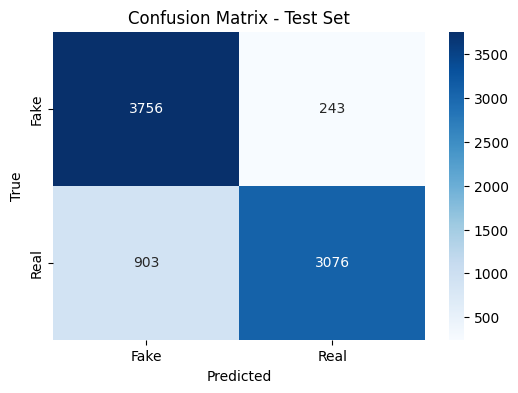

In [18]:
# Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=["Fake", "Real"], zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()
